In [1]:
import pandas as pd

import numpy as np

from scipy import stats

import sklearn

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler, LabelBinarizer

from sklearn_pandas import DataFrameMapper

from sklearn_pandas import gen_features

from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import Lasso, LassoCV

from sklearn.linear_model import Ridge, RidgeCV

from sklearn.linear_model import ElasticNet, ElasticNetCV

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score

from sklearn import metrics

import warnings

warnings.filterwarnings("ignore")

#### Loading the dataset

In [2]:
df = pd.read_csv('./Dataset/vehicles-cleaned-updated.csv')

df.head(3)

,make,mileage,price,body_type,drivetrain,transmission,fuel_type,passengers,is_private,car_age
0,PONTIAC,166014.0,8.006368,SEDAN,FWD,Automatic,Gas,5.0,1,15
1,ACURA,97902.0,10.126191,SUV,AWD,Automatic,Premium Unleaded,7.0,0,6
2,INFINITI,108000.0,8.764053,SEDAN,AWD,Automatic,Gas,5.0,1,17


#### Checking Multicollinearity Using VIF

In [3]:
variables = df[['mileage', 'passengers', 'car_age', 'is_private']]

vif = pd.DataFrame()

vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif["Features"] = variables.columns

vif

,VIF,Features
0,4.078037,mileage
1,3.069511,passengers
2,3.467800,car_age
3,1.668307,is_private


It looks good. We have VIFs < 5 and hence there is no Multicollinearity occurrence in our model.

#### Separating "Numeric" and "Catogories" types

In [4]:
train_clean_numeric = df.select_dtypes(include = [np.number])

train_clean_object = df.select_dtypes(include = 'object')

#### One-hot-encode

In [5]:
feature_def = gen_features(columns = train_clean_object.columns.tolist(), classes=[LabelBinarizer])

mapper5 = DataFrameMapper(feature_def,df_out=True)

object_df = mapper5.fit_transform(train_clean_object)

#### New dataframe for pre-processing

In [6]:
car = pd.concat([train_clean_numeric, object_df], axis = 1)

car.head(4)

,mileage,price,passengers,is_private,car_age,make_AC,make_ACURA,make_ALFA ROMEO,make_AM GENERAL,make_AMERICAN MOTORS (AMC),...,transmission_CVT,transmission_Manual,transmission_Sequential,fuel_type_Diesel,fuel_type_E85- Gas(Flex Fuel),fuel_type_Electric,fuel_type_Gas,fuel_type_Gas Hybrid,fuel_type_Premium Unleaded,fuel_type_Regular Unleaded
0,166014.0,8.006368,5.0,1,15,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,97902.0,10.126191,7.0,0,6,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,108000.0,8.764053,5.0,1,17,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,186750.0,10.428837,5.0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Declare the X and the y

In [7]:
y = car['price']

X = car.drop(['price'], axis = 1).values

#### Scale the data

In [8]:
# Create a scaler object

scaler = StandardScaler()

scaler.fit(X)

X_scaled = scaler.transform(X)

#### Train Test Split

In [9]:
# Split the variables with an 80-20 split and some random state. In order to have the same split as mine, use random_state = 365

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state = 365)

# Modeling

## Linear regression model

In [10]:
ln = LinearRegression()

ln.fit(X_train, y_train)

ln.score(X_train, y_train)

0.776482489118633

#### Predicting on the test set

In [11]:
predictions_ln = ln.predict(X_test)

R2_score_ln = metrics.r2_score(y_test, predictions_ln)

R2_score_ln

-2.0161046117277562e+25

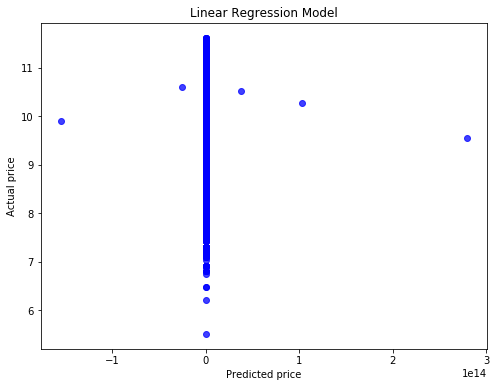

In [12]:
actual_values = y_test

plt.figure(figsize=(8,6))

plt.scatter(predictions_ln, actual_values, alpha= 0.75, color = 'b')

plt.xlabel('Predicted price')

plt.ylabel('Actual price')

plt.title('Linear Regression Model')

plt.show()

## Lasso Regression

In [13]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=0)

optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

0.0005443210022650681


In [14]:
lasso = Lasso(alpha = optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)

lasso.fit(X_train, y_train)

print(lasso_scores)

[0.76596213 0.78240189 0.76355534 0.77920871 0.76607388 0.78279202
 0.77580078 0.78166336 0.76710633 0.77594822]


In [15]:
print(np.mean(lasso_scores))

0.7740512666400547


#### Predicting on the test set

In [16]:
predictions_lasso = lasso.predict(X_test)

R2_score_lasso = metrics.r2_score(y_test, predictions_lasso)

R2_score_lasso

0.767723417638202

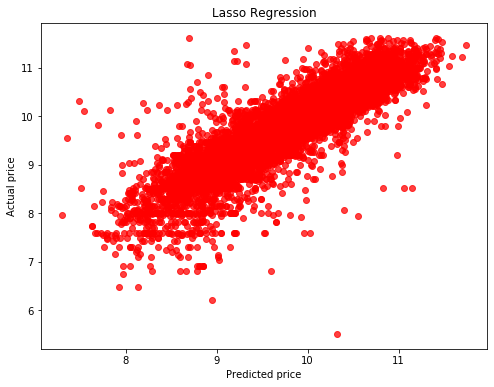

In [17]:
actual_values = y_test

plt.figure(figsize=(8,6))

plt.scatter(predictions_lasso, actual_values, alpha= 0.75, color = 'r')

plt.xlabel('Predicted price')

plt.ylabel('Actual price')

plt.title('Lasso Regression')

plt.show()

## Ridge Regression

In [18]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)

optimal_ridge.fit(X_train, y_train)

print(optimal_ridge.alpha_)

204.90746898158483


In [19]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)

ridge.fit(X_train, y_train)

print(ridge_scores)

[0.76581477 0.78220654 0.76353078 0.77930178 0.76581282 0.78295938
 0.77575937 0.78164423 0.76728305 0.77585445]


In [20]:
print(np.mean(ridge_scores))

0.7740167162703658


#### Predicting on the test set

In [21]:
predictions_ridge = ridge.predict(X_test)

R2_score_ridge = metrics.r2_score(y_test, predictions_ridge)

R2_score_ridge

0.7677502641029107

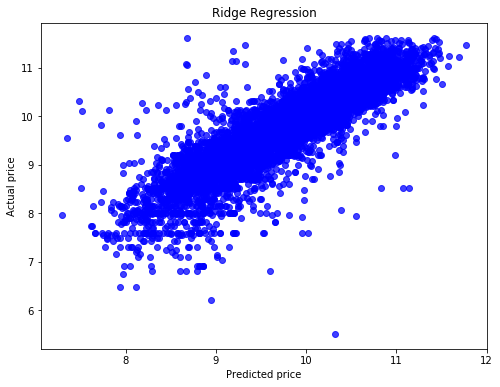

In [22]:
actual_values = y_test

plt.figure(figsize=(8,6))

plt.scatter(predictions_ridge, actual_values, alpha= 0.75, color = 'b')

plt.xlabel('Predicted price')

plt.ylabel('Actual price')

plt.title('Ridge Regression')

plt.show()

## ElasticNet Regression

In [23]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10, verbose=0)

optimal_enet.fit(X_train, y_train)

print(optimal_enet.alpha_)

0.0005443210022650681


In [24]:
print(optimal_enet.l1_ratio_)

1.0


In [25]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_train, y_train, cv=10)

enet.fit(X_train, y_train)

print(enet_scores)

[0.76596213 0.78240189 0.76355534 0.77920871 0.76607388 0.78279202
 0.77580078 0.78166336 0.76710633 0.77594822]


In [26]:
print(np.mean(enet_scores))

0.7740512666400547


#### Predicting on the test set

In [27]:
predictions_enet = enet.predict(X_test)

R2_score_enet = metrics.r2_score(y_test, predictions_enet)

R2_score_enet

0.767723417638202

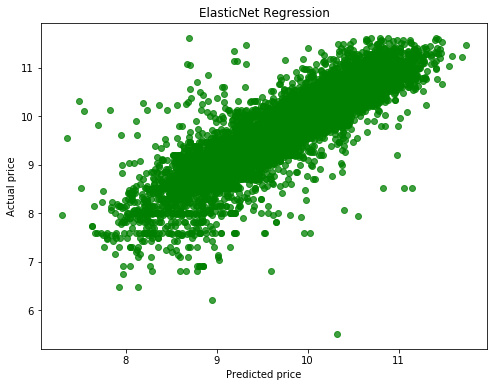

In [28]:
actual_values = y_test

plt.figure(figsize=(8,6))

plt.scatter(predictions_enet, actual_values, alpha= 0.75, color = 'g')

plt.xlabel('Predicted price')

plt.ylabel('Actual price')

plt.title('ElasticNet Regression')

plt.show()

### Choosing the right model

In [30]:
R2 = pd.DataFrame({'Linear Regression': [R2_score_ln], 'Ridge Regression': [R2_score_ridge], 
                   'Lasso Regression': [R2_score_lasso], 'ElasticNet Regression': [R2_score_enet]})

R2.T.sort_values(0, ascending = False)

,0
Ridge Regression,7.677503e-01
Lasso Regression,7.677234e-01
ElasticNet Regression,7.677234e-01
Linear Regression,-2.016105e+25
